<font size="5">**Cross validating the premodel**</font>
<br /><br />
<font size="3">All the timings and accuracy values are taken from the <font color = "green">database</font>. The average premodel feature extraction and prediction time were calculated <font color = "green">separately</font> and added to premodel inference time.</font>
 

<font size="3">First, we import the necessary libraries and start the *image generator* class.</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
import premodel
#!pip install --user imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
import image_generator
import database

In [2]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list()

images/val/images\ILSVRC2012_val_00049886.JPEG red fox, Vulpes vulpes
images/val/images\ILSVRC2012_val_00031610.JPEG minibus
images/val/images\ILSVRC2012_val_00002941.JPEG hard disc, hard disk, fixed disk
images/val/images\ILSVRC2012_val_00020002.JPEG cab, hack, taxi, taxicab
images/val/images\ILSVRC2012_val_00044853.JPEG gong, tam-tam
images/val/images\ILSVRC2012_val_00022971.JPEG monitor
images/val/images\ILSVRC2012_val_00015085.JPEG coral fungus
images/val/images\ILSVRC2012_val_00013839.JPEG cowboy hat, ten-gallon hat
images/val/images\ILSVRC2012_val_00005134.JPEG dock, dockage, docking facility
images/val/images\ILSVRC2012_val_00004285.JPEG bell pepper


<font size="5">**Running the premodel**</font>
<br /><br />
<font size="3">We cross validate two premodels (<font color = "green">logistic regression</font> and <font color = "green">knn</font>) with <font color = "green">10-fold cross validation</font> on <font color = "green">50k</font> images. So, we obtain the <u>predicted models</u> for all <font color = "green">50k</font> images.</font>

In [3]:
preference = 'Top-1'                # here, we select our preference, Top-1 or Top-5
n = 1                          # 1 for top-1, 5 for top-5
pre_model = premodel.Premodel(preference)

In [4]:
output_log_reg = pre_model.prototype(50000, ([('log_reg', 'log_reg', 'log_reg')]))  # logistic regression premodel

In [5]:
output_knn = pre_model.prototype(50000, ([('nn', 'nn', 'nn')]))      # knn premodel

<font size="5">**Testing the accuracy of the premodel**</font>
<br /><br />
<font size="3">First, we extract the predicted models for the 50k images for both <font color = "green">logistic regression</font> and <font color = "green">knn</font> premodels.</font>

In [6]:
def img_num_from_name(img_name):          # obtaining the image number from image name
    ext = []
    for i in range(len(img_name)):
        if i > 14 and i < 23:
            ext.append(img_name[i])
    j = 0
    for i in range(len(ext)):
        if ext[i] == '0':
            j = j + 1
        if ext[i] != '0':
            break
    rightNum = []
    for i in range(j, len(ext)):
        rightNum.append(ext[i])
    rightNum = ''.join(rightNum)
    rightNum = int(rightNum)
    return rightNum
            
# output_log_reg[5][i][1][0][j][0]         
# [5] the 6-th returned element that we need
# [i] the fold number - there are 10 folds
# [1][0] - accessing the nested list
# [j] = image number (inside the fold)
# [0] = image path
# [3] = predicted model

            
# output_log_reg[5][i][1][0][j][3]         
# [5] the 6-th returned element that we need
# [i] the fold number - there are 10 folds
# [1][0] - accessing the nested list
# [j] = image number (inside the fold)
# [0] = image path
# [3] = predicted model

predicted_models_log_reg = []                              # models predicted by logistic regression premodel
for i in range(10):
    for j in range(len(output_log_reg[5][i][1][0])):          
        img_paths = (output_log_reg[5][i][1][0][j][0])
        img_nums = (img_num_from_name(img_paths))
        if output_log_reg[5][i][1][0][j][3] == 1:
            predicted_models_log_reg.append([img_nums, 'mobilenet_v1'])
        elif output_log_reg[5][i][1][0][j][3] == 2:
            predicted_models_log_reg.append([img_nums, 'inception_v4'])
        elif output_log_reg[5][i][1][0][j][3] == 3:
            predicted_models_log_reg.append([img_nums, 'resnet_v1_152'])
        elif output_log_reg[5][i][1][0][j][3] == 0:
            predicted_models_log_reg.append([img_nums, 'failed'])
        

predicted_models_knn = []                                    # models predicted by knn premodel            
for i in range(10):
    for j in range(len(output_knn[5][i][1][0])):
        img_paths = (output_knn[5][i][1][0][j][0])
        img_nums = (img_num_from_name(img_paths))
        if output_knn[5][i][1][0][j][3] == 1:
            predicted_models_knn.append([img_nums, 'mobilenet_v1'])
        elif output_knn[5][i][1][0][j][3] == 2:
            predicted_models_knn.append([img_nums, 'inception_v4'])
        elif output_knn[5][i][1][0][j][3] == 3:
            predicted_models_knn.append([img_nums, 'resnet_v1_152'])
        elif output_knn[5][i][1][0][j][3] == 0:
            predicted_models_knn.append([img_nums, 'failed'])

In [7]:
print(len(predicted_models_log_reg))

50000


In [8]:
print(len(predicted_models_knn))

50000


In [9]:
def best_models(best_top_model_names):
    best_models = []
    for i in range(len(best_top_model_names)):
        if best_top_model_names[i][1] == 'mobilenet_v1':
            best_models.append([best_top_model_names[i][0], 1, 0, 0])
        elif best_top_model_names[i][1] == 'inception_v4':
            best_models.append([best_top_model_names[i][0], 0, 1, 0])
        elif best_top_model_names[i][1] == 'resnet_v1_152':
            best_models.append([best_top_model_names[i][0], 0, 0, 1])
        elif best_top_model_names[i][1] == 'failed':
            best_models.append([best_top_model_names[i][0], 0, 0, 0])
    return best_models

In [10]:
predicted_models_knn.sort(key = lambda tup: tup[0])
predicted_models_log_reg.sort(key = lambda tup: tup[0])

In [11]:
knn_predictions = best_models(predicted_models_knn)
log_reg_predictions = best_models(predicted_models_log_reg)

In [12]:
import csv, sys

filename = 'knn_predictions.csv'
with open('knn_predictions.csv', mode='w', newline='') as featuresFile1:
    features_writer = csv.writer(featuresFile1, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152'])
    for i in range(len(knn_predictions)):
        row = ([knn_predictions[i][0], knn_predictions[i][1], knn_predictions[i][2], knn_predictions[i][3]])
        features_writer.writerow(row)

In [13]:
filename = 'log_reg_predictions.csv'
with open('log_reg_predictions.csv', mode='w', newline='') as featuresFile1:
    features_writer = csv.writer(featuresFile1, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152'])
    for i in range(len(knn_predictions)):
        row = ([log_reg_predictions[i][0], log_reg_predictions[i][1], log_reg_predictions[i][2], log_reg_predictions[i][3]])
        features_writer.writerow(row)

<font size="3">Now, we obtain the <font color = "green">accuracy</font> and <font color = "green">inference time</font> results of the predicted models from the database.</font>

In [14]:
def get_performance_premodel(predicted_models, premodel_overhead):
    accuracy = 0
    time = 0
    times = 0
    for i in range(len(predicted_models)):
        if predicted_models[i][1] != 'failed':
            times = times + 1
            accuracy = accuracy + (database.get_model_top_n("inference", predicted_models[i][0], predicted_models[i][1], n))
            time = time + (database.get_model_time("inference", predicted_models[i][0], predicted_models[i][1]))
    return accuracy/len(predicted_models), (time/times) + premodel_overhead

In [15]:
log_reg_accuracy, log_reg_time = get_performance_premodel(predicted_models_log_reg, 53.16788)
print("Logistic regression premodel accuracy = {}".format(log_reg_accuracy))
print("Logistic regression premodel average inference time = {}".format(log_reg_time))

Logistic regression premodel accuracy = 0.76692
Logistic regression premodel average inference time = 476.27206


In [16]:
knn_accuracy, knn_time = get_performance_premodel(predicted_models_knn,  51.74009)
print("KNN premodel accuracy = {}".format(knn_accuracy))
print("KNN premodel average inference time = {}".format(knn_time))

KNN premodel accuracy = 0.7515
KNN premodel average inference time = 475.09619660581114


<font size="5">**Comparing the results to MobileNet, Inception and ResNet**</font>
<br /><br />
<font size="3">We start by getting the <font color = "green">image numbers</font> of the 50k images.</font>

In [17]:
img_nums = []
for i in range(1, 50001):                        # the same range of images is selected
    img_nums.append(i)

<font size="3">Finally, we obtain the <font color = "green">accuracy</font> and <font color = "green">inference time</font> results for each DNN separately from the database.</font>

In [18]:
def get_performance_DNN(DNN_model_name):
    accuracy = 0
    time = 0
    for i in range(len(img_nums)):                            # obtaining accuracy and inference time for each image
        accuracy = accuracy + (database.get_model_top_n("inference", img_nums[i], DNN_model_name, n))
        time = time + (database.get_model_time("inference", img_nums[i], DNN_model_name))
    return accuracy/len(img_nums), time/len(img_nums)

In [19]:
mobilenet_accuracy, mobilenet_time = get_performance_DNN("mobilenet_v1")
print("Mobilenet top-{} accuracy = {}".format(n, mobilenet_accuracy))          # accuracy over 20k images
print("Mobilenet average inference time = {}".format(mobilenet_time))   # average inference time over 20k images


inception_accuracy, inception_time = get_performance_DNN("inception_v4")
print("Inception top-{} accuracy = {}".format(n, inception_accuracy))
print("Inception average inference time = {}".format(inception_time))


resnet_accuracy, resnet_time = get_performance_DNN("resnet_v1_152")
print("ResNet top-{} accuracy = {}".format(n, resnet_accuracy))
print("ResNet average inference time = {}".format(resnet_time))

Mobilenet top-1 accuracy = 0.7102
Mobilenet average inference time = 107.24932
Inception top-1 accuracy = 0.80184
Inception average inference time = 640.85854
ResNet top-1 accuracy = 0.76798
ResNet average inference time = 730.63198


<font size="3">Here, we plot the results for comparison.</font>

In [20]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


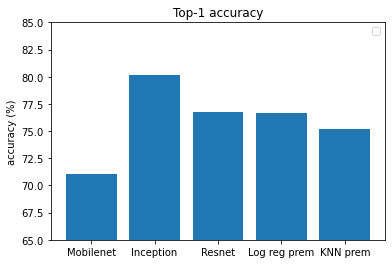

In [21]:
model_names = ['Mobilenet', 'Inception', 'Resnet', 'Log reg prem', 'KNN prem']
accuracy = [mobilenet_accuracy, inception_accuracy,
            resnet_accuracy, log_reg_accuracy, knn_accuracy]

for i in range(len(accuracy)):
    accuracy[i] = accuracy[i]*100

ypos = np.arange(len(model_names))

plt.xticks(ypos, model_names)
plt.ylabel("accuracy (%)")
plt.title("{} accuracy".format(preference))
plt.bar(ypos, accuracy)
plt.ylim(top = 85)
plt.ylim(bottom = 65)
plt.legend()

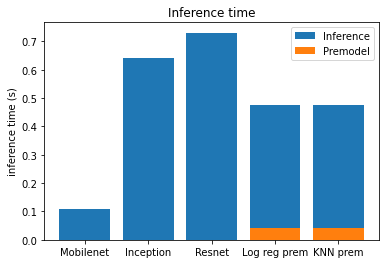

In [22]:
times = [mobilenet_time, inception_time,
         resnet_time, log_reg_time, knn_time]
times_premodel = [0, 0, 0, 42.39268, 43.00882]

for i in range(len(times)):
    times[i] = times[i]/1000

for i in range(len(times_premodel)):
    times_premodel[i] = times_premodel[i]/1000
    
plt.xticks(ypos, model_names)
plt.ylabel("inference time (s)")
plt.title("Inference time")
plt.bar(ypos, times, label = "Inference")
plt.bar(ypos, times_premodel, label = "Premodel")
plt.legend()